# EDA

## 1. Load cleaned data

In [40]:
# Standard imports
from geopy.geocoders import Nominatim
from geopy.exc import  GeocoderTimedOut, GeocoderUnavailable
from haversine import haversine
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar, Generic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager


In [2]:

data_path_manager = DataPathCleaningManager(data_timeplace)

df_olx = data_path_manager.load_df(domain="olx", is_cleaned=True)
df_otodom = data_path_manager.load_df(domain="otodom", is_cleaned=True)

### 1.1 OLX

In [3]:
df_olx

,link,title,price,summary_description,ownership,floor_level,is_furnished,building_type,square_meters,number_of_rooms,rent,voivodeship,city,street
0,https://www.olx.pl/d/oferta/kawalerka-tychy-os...,Kawalerka Tychy oś M,1500.0,OpisWynajmę kawalerkę na ul Moniuszki 1/16 .na...,private,3,False,apartment_building,26,1,400.0,Śląskie,Zawada,Moniuszki 1/16


In [4]:
df_olx.columns

Index(['link', 'title', 'price', 'summary_description', 'ownership',
       'floor_level', 'is_furnished', 'building_type', 'square_meters',
       'number_of_rooms', 'rent', 'voivodeship', 'city', 'street'],
      dtype='object')

### 1.2 otodom

In [5]:
df_otodom.sample(5)

listing  \
                                                   link   
536   https://www.otodom.pl/pl/oferta/2-pok-mieszkan...   
916   https://www.otodom.pl/pl/oferta/mieszkanie-34-...   
255   https://www.otodom.pl/pl/oferta/wynajme-mieszk...   
1098  https://www.otodom.pl/pl/oferta/lux-kawalerka-...   
750   https://www.otodom.pl/pl/oferta/nowoczesne-i-n...   

                                                        \
                                                 title   
536          2-pok. mieszkanie, Katowice, Tysiąclecia,   
916                           Mieszkanie, 34 m², Bytom   
255     Wynajmę mieszkanie, prywatny ogrodzony teren!!   
1098    LUX Kawalerka - Katowice 1 Maja - blisko UE/UŚ   
750   NOWOCZESNE i Nowe - Bytkowska 2.0. - Od zaraz !!   

                                                                        \
                                    summary_description remote_service   
536   Mamy przyjemność zaprezentować Państwu 2 pokoj...           <NA>   
916   Do wynajęcia proponujemy mieszkanie zlokalizow...           <NA>   
255   Do wynajęcia od zaraz mieszkanie  o powierzchn...           <NA>   
1098  Oferujemy Państwu do wynajęcia funkcjonalną, n...    unspecified   
750   NOWE MIESZKANIE „BYTKOWSKA 2.0.”– NOWOCZESNY B...    unspecified   

     pricing                            \
       price   rent total_rent deposit   
536   1600.0  600.0     2200.0  2000.0   
916   1200.0    NaN     1200.0     NaN   
255   2200.0  200.0     2400.0  4000.0   
1098  1100.0  460.0     1560.0  1500.0   
750   2500.0  620.0     3120.0     NaN   

                                               location  \
                                       complete_address   
536   ul. Tysiąclecia, Osiedle Tysiąclecia, Katowice...   
916                             Rozbark, Bytom, śląskie   
255   ul. Gabriela Narutowicza 7, Stroszek - Dąbrowa...   
1098            ul. 1 Maja, Zawodzie, Katowice, śląskie   
750   ul. Bytkowska, Wełnowiec-Józefowiec, Katowice,...   

                                  ... building_material              \
                          street  ...          silicate large_panel   
536              ul. Tysiąclecia  ...             False       False   
916                      Rozbark  ...             False       False   
255   ul. Gabriela Narutowicza 7  ...             False       False   
1098                  ul. 1 Maja  ...             False        True   
750                ul. Bytkowska  ...             False       False   

                         additional_information                          \
     reinforced_concrete         no_information duplex air_conditioning   
536                False                  False  False            False   
916                False                  False   True            False   
255                False                  False  False            False   
1098               False                  False  False            False   
750                False                   True  False            False   

                                                              
     separate_kitchen basement utility_room non_smokers_only  
536             False     True        False            False  
916             False    False        False            False  
255              True     True         True            False  
1098            False    False        False             True  
750             False    False        False            False  

[5 rows x 73 columns]

In [6]:
df_otodom.columns

MultiIndex([(               'listing',                           'link'),
            (               'listing',                          'title'),
            (               'listing',            'summary_description'),
            (               'listing',                 'remote_service'),
            (               'pricing',                          'price'),
            (               'pricing',                           'rent'),
            (               'pricing',                     'total_rent'),
            (               'pricing',                        'deposit'),
            (              'location',               'complete_address'),
            (              'location',                         'street'),
            (              'location',                           'city'),
            (              'location',                    'voivodeship'),
            (                  'size',                  'square_meters'),
            (                  'size',

### 1.3 Combined

In [7]:
def combine_olx_otodom(df_olx: pd.DataFrame = df_olx, df_otodom: pd.DataFrame = df_otodom):

    # Step 1: Create a mapping
    column_mapping = {
        'link': ('listing', 'link'),
        'title': ('listing', 'title'),
        'price': ('pricing', 'price'),
        'rent': ('pricing', 'rent'),
        'summary_description': ('listing', 'summary_description'),
        'ownership': ('legal_and_availability', 'ownership'),
        'floor_level': ('size', 'floor'),
        'is_furnished': ('equipment', 'furniture'),
        'building_type': ('type_and_year', 'building_type'),
        'square_meters': ('size', 'square_meters'),
        'number_of_rooms': ('size', 'number_of_rooms'),
        'rent': ('pricing', 'rent'),
        'voivodeship': ('location', 'voivodeship'),
        'city': ('location', 'city'),
        'street': ('location', 'street')
    }

    # Step 2: Modify df_olx to have a MultiIndex
    df_olx.columns = pd.MultiIndex.from_tuples([column_mapping[col] if col in column_mapping else (col, '') for col in df_olx.columns])

    # Step 3: Fill missing columns in df_olx
    # Identify missing columns
    missing_columns = set(df_otodom.columns) - set(df_olx.columns)

    # Fill missing columns with NaN or False
    for col in missing_columns:
        if col in [('equipment', 'furniture'),]:  # Add other boolean columns if any
            df_olx[col] = False
        else:
            df_olx[col] = np.nan

    # Reorder df_olx columns to match df_otodom
    df_olx = df_olx.reindex(columns=df_otodom.columns)

    # Add total_rent column
    df_olx[('pricing', 'total_rent')] = df_olx[('pricing', 'price')].add(df_olx[('pricing', 'rent')], fill_value=0)

    # Create complete_address column
    df_olx[('location', 'complete_address')] = df_olx.apply(
    lambda row: ', '.join(
        filter(None, [row[('location', 'street')], row[('location', 'city')], row[('location', 'voivodeship')]])
    ),
    axis=1
)
    pd.set_option('display.max_rows', None)
    df_olx.iloc[0]

    # Fill NaNs
    # Replacing NaN with False
    columns_to_fill_false = [
        ('size', 'attic'),
        ('amenities', 'elevator'),
        ('amenities', 'parking_space'),
        ('equipment', 'no_information'),
        ('equipment', 'stove'),
        ('equipment', 'fridge'),
        ('equipment', 'oven'),
        ('equipment', 'washing_machine'),
        ('equipment', 'TV'),
        ('equipment', 'dishwasher'),
        ('media_types', 'internet'),
        ('media_types', 'telephone'),
        ('media_types', 'cable_TV'),
        ('heating', 'electric'),
        ('heating', 'gas'),
        ('heating', 'other'),
        ('heating', 'boiler_room'),
        ('heating', 'district'),
        ('heating', 'tile_stove'),
        ('security', 'intercom_or_video_intercom'),
        ('security', 'anti_burglary_doors_or_windows'),
        ('security', 'monitoring_or_security'),
        ('security', 'anti_burglary_roller_blinds'),
        ('security', 'alarm_system'),
        ('security', 'enclosed_area'),
        ('windows', 'aluminum'),
        ('windows', 'wooden'),
        ('windows', 'plastic'),
        ('building_material', 'concrete'),
        ('building_material', 'aerated_concrete'),
        ('building_material', 'brick'),
        ('building_material', 'wood'),
        ('building_material', 'other'),
        ('building_material', 'lightweight_aggregate'),
        ('building_material', 'hollow_brick'),
        ('building_material', 'silicate'),
        ('building_material', 'large_panel'),
        ('building_material', 'reinforced_concrete'),
        ('additional_information', 'duplex'),
        ('additional_information', 'air_conditioning'),
        ('additional_information', 'separate_kitchen'),
        ('additional_information', 'basement'),
        ('additional_information', 'utility_room'),
        ('additional_information', 'non_smokers_only'),
    ] 
    for col in columns_to_fill_false:
        df_olx[col] = df_olx[col].fillna(False)

    # Replacing NaN with True
    columns_to_fill_true = [
        ('media_types', 'no_information'),
        ('heating', 'no_information'),
        ('security', 'no_information'),
        ('windows', 'no_information'),
        ('building_material', 'no_information'),
        ('additional_information', 'no_information'),
    ]

    for col in columns_to_fill_true:
        df_olx[col] = df_olx[col].fillna(True)

    # Step 5: Set the same dtypes for df_olx as in df_otodom
    for column in df_otodom.columns:
        if column in df_olx.columns:
            df_olx[column] = df_olx[column].astype(df_otodom[column].dtype)


    # Step 6: Append df_olx to df_otodom
    combined_df = pd.concat([df_otodom, df_olx], ignore_index=True)

    # Step 7: Add deposit_ratio column
    combined_df.loc[:, ("pricing", "deposit_ratio")] = np.where(
        combined_df["pricing"]["total_rent"] != 0,
        (combined_df["pricing"]["deposit"] / combined_df["pricing"]["total_rent"]).round(2),
        np.nan  # or 0, depending on your preference for default value
    )

    columns = combined_df.columns.tolist()
    new_col_index = columns.index(("pricing", "deposit_ratio"))
    desired_position = 8
    columns.insert(desired_position, columns.pop(new_col_index))

    combined_df = combined_df[columns]
    return combined_df

combined_df = combine_olx_otodom(df_olx, df_otodom)

combined_df.tail()

listing  \
                                                   link   
1101  https://www.otodom.pl/pl/oferta/katowice-ligot...   
1102  https://www.otodom.pl/pl/oferta/katowice-centr...   
1103  https://www.otodom.pl/pl/oferta/kawalerka-bryn...   
1104  https://www.otodom.pl/pl/oferta/wynajme-mieszk...   
1105  https://www.olx.pl/d/oferta/kawalerka-tychy-os...   

                                                    \
                                             title   
1101  Katowice Ligota Koszalińska pokój blisko Śum   
1102       Katowice centrum 2 pokoje dla studentów   
1103                              Kawalerka Brynów   
1104        Wynajmę Mieszkanie / Pogoń / Sosnowiec   
1105                          Kawalerka Tychy oś M   

                                                                        \
                                    summary_description remote_service   
1101  Wynajem pokoju w bardzo dobrej lokalizacji. Ni...           <NA>   
1102  OFERTA POLECANA! Oferujemy do wynajęcia przytu...   virtual_tour   
1103  Kawalerka Katowice Brynów bardzo spokojne miej...           <NA>   
1104  Wynajmę mieszkanie 56 m2 , dwa pokoje , kuchni...           <NA>   
1105  OpisWynajmę kawalerkę na ul Moniuszki 1/16 .na...           <NA>   

     pricing                                          \
       price   rent total_rent deposit deposit_ratio   
1101   800.0    NaN      800.0  1200.0          1.50   
1102  1499.0    NaN     1499.0  3000.0          2.00   
1103  1300.0    NaN     1300.0  2600.0          2.00   
1104   700.0    NaN      700.0  2000.0          2.86   
1105  1500.0  400.0     1900.0     NaN           NaN   

                                       location  ... building_material  \
                               complete_address  ...          silicate   
1101        Ligota-Panewniki, Katowice, śląskie  ...             False   
1102             Śródmieście, Katowice, śląskie  ...             False   
1103    Załęska Hałda-Brynów, Katowice, śląskie  ...             False   
1104  ul. Mazowiecka, Pogoń, Sosnowiec, śląskie  ...             False   
1105            Moniuszki 1/16, Zawada, Śląskie  ...             False   

                                     additional_information         \
     large_panel reinforced_concrete         no_information duplex   
1101       False               False                  False  False   
1102       False               False                  False  False   
1103       False               False                  False  False   
1104       False               False                  False  False   
1105       False               False                   True  False   

                                                                               
     air_conditioning separate_kitchen basement utility_room non_smokers_only  
1101            False             True    False        False            False  
1102            False             True     True        False            False  
1103            False             True     True        False            False  
1104            False            False     True        False            False  
1105            False            False    False        False            False  

[5 rows x 74 columns]

In [8]:
pd.reset_option('display.max_rows')

In [9]:
combined_df.dtypes.to_dict()

{('listing', 'link'): string[python],
 ('listing', 'title'): string[python],
 ('listing', 'summary_description'): string[python],
 ('listing', 'remote_service'): string[python],
 ('pricing', 'price'): dtype('float64'),
 ('pricing', 'rent'): dtype('float64'),
 ('pricing', 'total_rent'): dtype('float64'),
 ('pricing', 'deposit'): dtype('float64'),
 ('pricing', 'deposit_ratio'): dtype('float64'),
 ('location', 'complete_address'): string[python],
 ('location', 'street'): string[python],
 ('location', 'city'): string[python],
 ('location', 'voivodeship'): string[python],
 ('size', 'square_meters'): Int64Dtype(),
 ('size', 'number_of_rooms'): Int64Dtype(),
 ('size', 'floor'): Int64Dtype(),
 ('size', 'attic'): dtype('bool'),
 ('size', 'building_floors'): Int64Dtype(),
 ('legal_and_availability', 'available_from'): string[python],
 ('legal_and_availability', 'completion'): string[python],
 ('legal_and_availability', 'ownership'): string[python],
 ('legal_and_availability', 'rent_to_students')

In [10]:
data_path_manager.save_df(combined_df, domain="combined")

In [11]:
saved_combined = data_path_manager._load_cleaned_df(domain="combined")
saved_combined.sample(5)

listing  \
                                                   link   
960   https://www.otodom.pl/pl/oferta/wojewodzka-fra...   
812   https://www.otodom.pl/pl/oferta/przestronne-mi...   
821   https://www.otodom.pl/pl/oferta/wyposazona-kaw...   
1079  https://www.otodom.pl/pl/oferta/swiezo-wyremon...   
348   https://www.otodom.pl/pl/oferta/mieszkanie-67-...   

                                                         \
                                                  title   
960               Wojewódzka Francuska piękne 132 m2 M5   
812   Przestronne mieszkanie na wynajem 49m2, Dąbrow...   
821          Wyposażona kawalerka do wynajęcia- Podwale   
1079            Świeżo wyremontowane w pełni wyposażone   
348                         Mieszkanie, 67 m², Katowice   

                                                                        \
                                    summary_description remote_service   
960   Wojewódzka Francuska piękne 132 m2 M5Do wynaję...           <NA>   
812   Przedstawiamy Państwu ofertę wynajmu 2 - pokoj...    unspecified   
821   Przytulna i wyposażona kawalerka do wynajęcia-...           <NA>   
1079  Przedstawiamy Państwu piękne, świeżo wyremonto...           <NA>   
348   Zapraszam Państwa do zapoznania się z bardzo a...           <NA>   

     pricing                                          \
       price   rent total_rent deposit deposit_ratio   
960   2600.0  415.0     3015.0     NaN           NaN   
812   1799.0  640.0     2439.0  2500.0          1.03   
821   1100.0  315.0     1415.0  2000.0          1.41   
1079  1800.0  400.0     2200.0  2000.0          0.91   
348   4500.0    NaN     4500.0     NaN           NaN   

                                               location  ...  \
                                       complete_address  ...   
960      ul. Wojewódzka, Śródmieście, Katowice, śląskie  ...   
812   ul. Cypriana Kamila Norwida, Aleje, Reden, Dąb...  ...   
821                                   Jaworzno, śląskie  ...   
1079                        Śródmieście, Bytom, śląskie  ...   
348   Pierwsza Dzielnica, ulica Góreckiego, Bogucice...  ...   

     building_material                                 additional_information  \
              silicate large_panel reinforced_concrete         no_information   
960              False       False               False                  False   
812              False       False               False                  False   
821              False       False               False                  False   
1079             False       False               False                  False   
348              False       False               False                  False   

                                                                     \
     duplex air_conditioning separate_kitchen basement utility_room   
960   False             True             True    False         True   
812   False            False             True     True        False   
821   False            False            False     True        False   
1079  False            False             True    False        False   
348   False            False             True    False        False   

                       
     non_smokers_only  
960             False  
812             False  
821             False  
1079            False  
348             False  

[5 rows x 74 columns]

In [12]:
del df_olx, df_otodom, saved_combined, data_path_manager, data_timeplace

In [13]:
combined_df[('listing', 'link')].duplicated().sum()

0

## 2. EDA

### 2.1 Numerical data

In [14]:
combined_df.describe()

pricing                                                        \
              price        rent    total_rent       deposit deposit_ratio   
count   1106.000000  593.000000   1106.000000    742.000000    742.000000   
mean    2180.465642  463.910624   2429.198915   3477.051213      1.457399   
std     1429.766366  252.601285   1442.413882   3698.524190      0.848110   
min      500.000000    1.000000    500.000000      2.000000      0.000000   
25%     1500.000000  300.000000   1687.000000   2000.000000      1.000000   
50%     1900.000000  500.000000   2200.000000   3000.000000      1.295000   
75%     2500.000000  650.000000   2800.000000   3800.000000      1.760000   
max    19000.000000  990.000000  19001.000000  57000.000000     12.000000   

               size                                           type_and_year  
      square_meters number_of_rooms     floor building_floors    build_year  
count        1106.0          1106.0    1083.0           979.0    476.000000  
mean      49.740506        2.119349  2.757156         5.48621   1993.170168  
std       26.233006        0.858414   2.57227        3.828449     33.635859  
min             8.0             1.0      -1.0             1.0   1893.000000  
25%            36.0             2.0       1.0             3.0   1975.000000  
50%            45.0             2.0       2.0             4.0   2011.500000  
75%            56.0             3.0       4.0             7.0   2021.000000  
max           413.0             6.0      11.0            25.0   2025.000000

In [15]:
len(combined_df)

1106

The 11th floor is 10+

**Insights:**

1. **The offers**<br>
Are in the radius of the area of `25km`<br>
from `"Mierzęcice, Będziński, Śląskie"`, near the regional international airport.<br>
The total number of offers is `1106`.
1. **Average Total Rent**:<br>
The median total rent (total_rent) is `2200.00 PLN`.
1. **Rent Range and Standard Deviation**:<br>
The total rent ranges from a minimum of `500` to a maximum of `19,001`, with a standard deviation of `1442.41`.<br>This wide range and high standard deviation indicate a significant variation in rent prices
1. **Property Size:**<br>
The average size of the properties is about `49.74` square meters.<br>The smallest property is `8`square meters, and the largest is `413` square meters.
1. **Build Year**:<br>
The properties in the dataset were built between `1893` and `2025`, with a median build year of `2011`.<br>The data includes a wide range of property ages, from historical to modern constructions.
1. **Floor Information**:<br>The median floor on which properties are located is `2nd` one, with properties ranging from the basement level (`-1`) to the `10 and higher` floor. The median number of floors in the buildings is about `4`, suggesting that most properties are in low to mid-rise buildings.

### 2.2 Total rent

In [16]:
def advanced_statistical_analysis(df: pd.DataFrame = combined_df):
    price_data = df['pricing']['total_rent']

    # Central Tendency Measures
    mean_price = price_data.mean()
    median_price = price_data.median()
    mode_price = price_data.mode()[0]

    # Variability Measures
    std_dev_price = price_data.std()
    variance_price = price_data.var()
    range_price = price_data.max() - price_data.min()
    iqr_price = np.percentile(price_data, 75) - np.percentile(price_data, 25)

    # Skewness and Kurtosis
    skewness_price = price_data.skew()
    kurtosis_price = price_data.kurtosis()

    # Quantile Analysis
    quantiles_price = price_data.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

    # Outlier Detection: Using the 1.5*IQR rule
    lower_bound = np.percentile(price_data, 25) - 1.5 * iqr_price
    upper_bound = np.percentile(price_data, 75) + 1.5 * iqr_price
    outliers_upper = price_data[(price_data >= upper_bound)].count()
    outliers_lower = price_data[(price_data <= lower_bound)].count()
    outlier_total = outliers_upper + outliers_lower

    advanced_statistics = {
        "Mean": mean_price.round(2),
        "Median": median_price,
        "Standard Deviation": std_dev_price.round(2),
        "Mode": mode_price,
        "Variance": variance_price.round(2),
        "Range": range_price,
        "Interquartile Range (IQR)": iqr_price,
        "Skewness": skewness_price.round(2),
        "Kurtosis": kurtosis_price.round(2),
        "Quantiles": quantiles_price,
        "Outlier Lower Bound": lower_bound,
        "Outlier Upper Bound": upper_bound,
        "Number of Lower Bound": outliers_upper,
        "Number of Upper Bound": outliers_lower,
        "Number of Outliers": outlier_total,
        "Total Number of Listings": price_data.count(),
        "Ratio of Outliers to Total Listings": str((outlier_total / price_data.count()).round(2) * 100)+ "%",
    }

    print("Total Price, Advanced Statistics:")
    return advanced_statistics

advanced_statistical_analysis(combined_df)

Total Price, Advanced Statistics:


{'Mean': 2429.2,
 'Median': 2200.0,
 'Standard Deviation': 1442.41,
 'Mode': 1500.0,
 'Variance': 2080557.81,
 'Range': 18501.0,
 'Interquartile Range (IQR)': 1113.0,
 'Skewness': 4.89,
 'Kurtosis': 41.71,
 'Quantiles': 0.25    1687.0
 0.50    2200.0
 0.75    2800.0
 0.90    3557.5
 0.95    4569.5
 0.99    7270.0
 Name: total_rent, dtype: float64,
 'Outlier Lower Bound': 17.5,
 'Outlier Upper Bound': 4469.5,
 'Number of Lower Bound': 67,
 'Number of Upper Bound': 0,
 'Number of Outliers': 67,
 'Total Number of Listings': 1106,
 'Ratio of Outliers to Total Listings': '6.0%'}

**Insights:**

1. **Rent Tendency**:<br>
Most rent prices are on the lower side, but a few are very high.<br>
This "lopsided" pattern means a lot of rents are more affordable, while only a handful are really expensive.

1. **Exceptional Rents**:<br>
About `6%` of the rent prices are way higher or lower than what's typical.<br>
These few unusual rents can make the average look higher than what most people see.

1. **Variation in Rent Prices**:<br>
Analyzing the rent data reveals a broad spectrum.<br>
Most of the rents `(75%)` are reasonably priced, under a certain level.<br>
However, when you look at the higher end, the rents take a significant jump.<br>
The top `5%` of properties have rents much higher than average,<br>
and the top `1%` are in an even more exclusive price range.<br>
This shows a clear distinction between the majority of affordable rentals and<br>
a smaller segment of premium, high-priced properties.

In [17]:
combined_df['size']['number_of_rooms'].dtype

Int64Dtype()

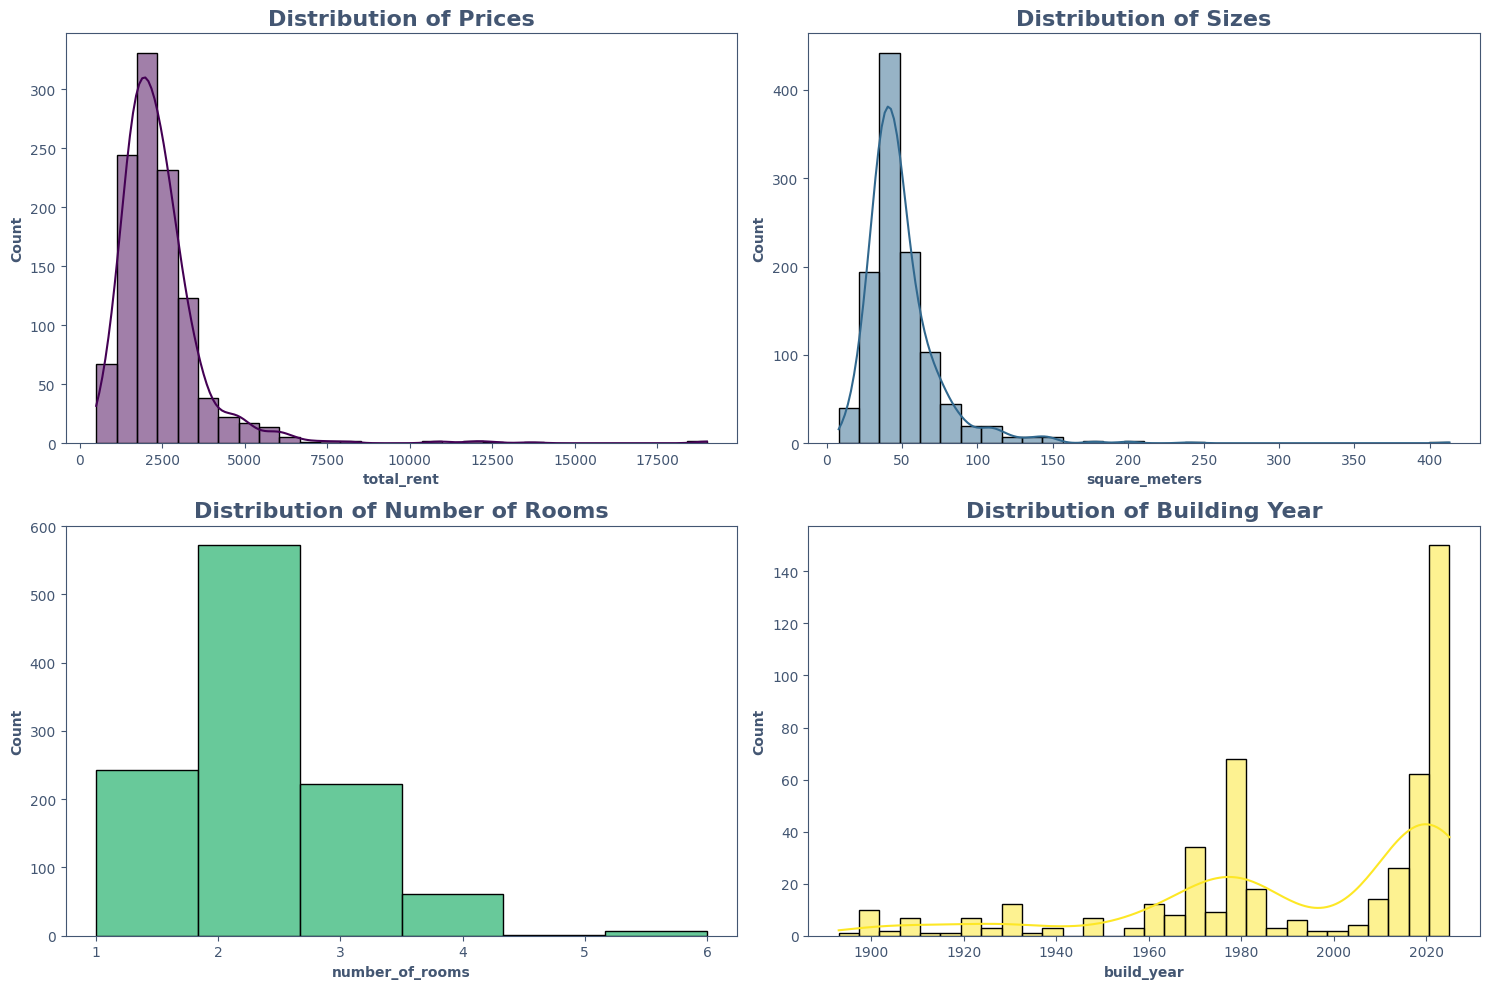

In [18]:
aesthetics_plots = {
	'title_size': 16,
	'fontweight': 'bold',
	'label_color': "#435672",
    "palette": "viridis",
    "figsize": {
        "multiplot": (15, 10),  # (width, height) in inches
        "singleplot": (8, 6),
        },
    }


def set_plot_aesthetics(
        ax: plt.Axes, 
        title: str, 
        title_fontsize: int = aesthetics_plots['title_size'], 
        color: str =aesthetics_plots['label_color'], 
        fontweight: str =aesthetics_plots['fontweight']
    ):


    ax.set_title(title, fontsize=title_fontsize, color=color, fontweight=fontweight)
    ax.set_xlabel(ax.get_xlabel(), fontweight=fontweight)
    ax.set_ylabel(ax.get_ylabel(), fontweight=fontweight)
    ax.tick_params(colors=color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(color)  # Y-axis label color
    ax.xaxis.label.set_color(color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(color)

def plot_distribution(combined_df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=aesthetics_plots['figsize']['multiplot'])

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))

    titles = ['Distribution of Prices', 'Distribution of Sizes', 'Distribution of Number of Rooms', 'Distribution of Building Year']
    data_columns = ['pricing.total_rent', 'size.square_meters', 'size.number_of_rooms', 'type_and_year.build_year']
    kde_settings = [True, True, False, True]
    bins = [30, 30, 6, 30]

    for ax, title, color, data_column, kde_setting, bin in zip(axes.flat, titles, colors, data_columns, kde_settings, bins):
        sns.histplot(combined_df[data_column.split('.')[0]][data_column.split('.')[1]].astype('float'), ax=ax, kde=kde_setting, bins=bin, color=color)
        set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(combined_df)

**Insights:**

1. **Rental Prices**:<br>
Most rents are low, with a common amount around `2500`. There aren't many pricey places to rent.

1. **Apartment Sizes**:<br>
Smaller apartments are more common (around `50 m2`) than larger ones, with very few big apartments available.
Most have only `2` rooms extra besides the bathroom and kitchen or corridor.

1. **Building Ages**:<br>
A lot of buildings were put up around the year `1980`, and there's a recent surge in new ones in `2020`.<br>
You don't see many old buildings up for rent.

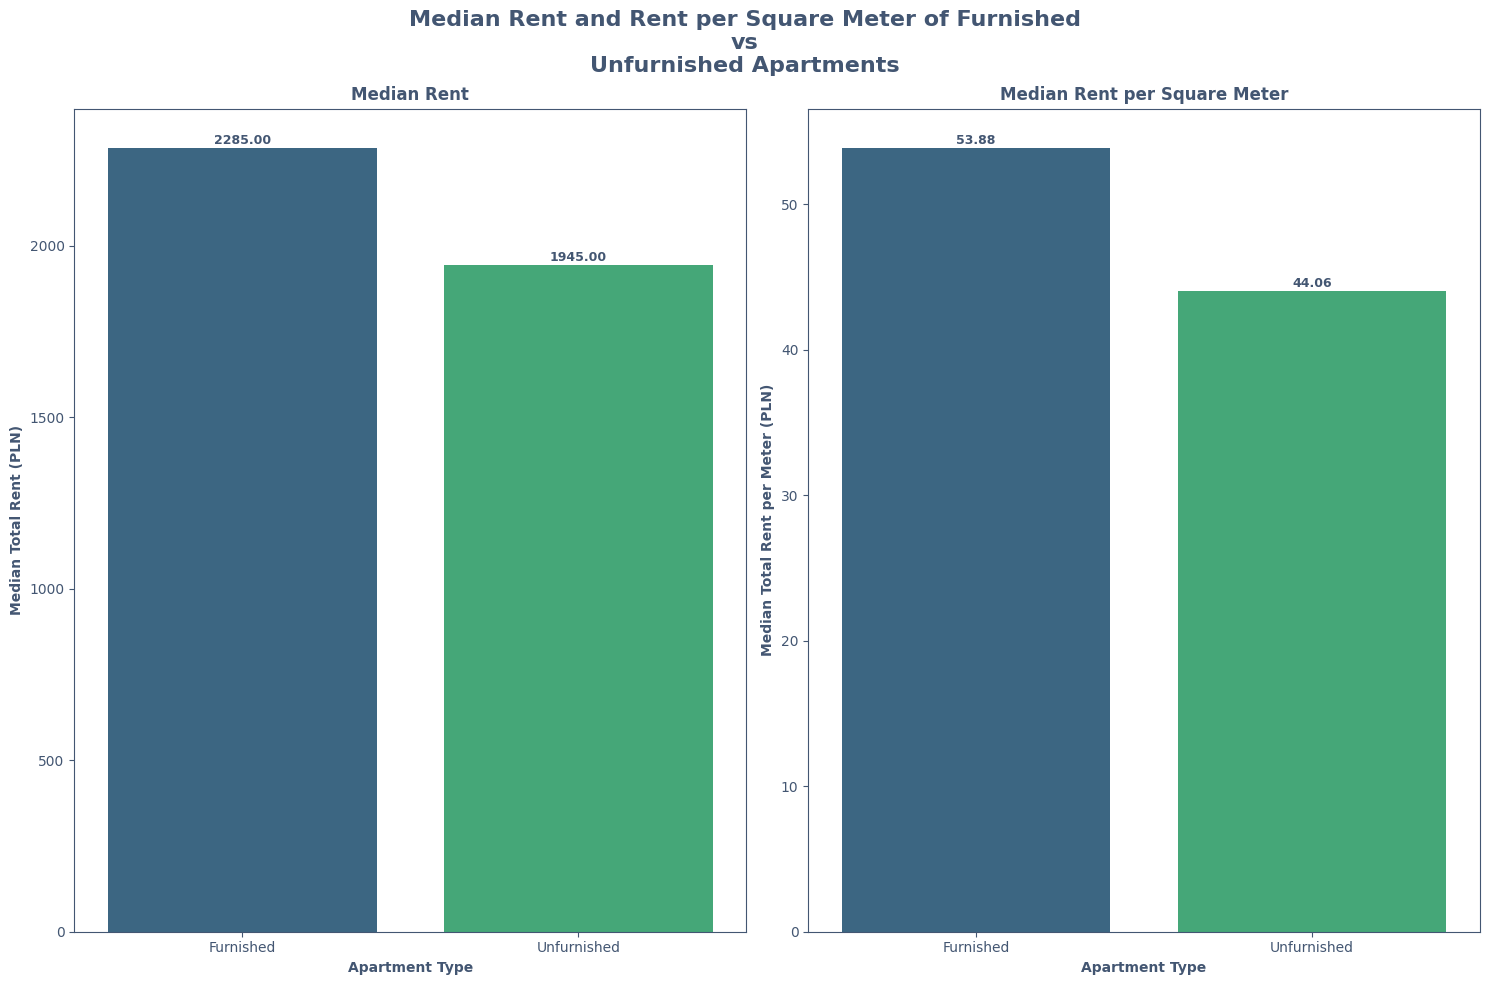

Median Differences:
Furnished vs Unfurnished: 340.0 PLN
Furnished vs Unfurnished per Square Meter: 10.0 PLN


In [19]:
def set_plot_aesthetics(ax, title=None, xlabel=None, ylabel=None, title_color="#435672", tick_color="#435672", fontweight='bold'):
    if title:
        ax.set_title(title, color=title_color, fontweight=fontweight)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight=fontweight)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight=fontweight)
    ax.tick_params(colors=tick_color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(tick_color)  # Y-axis label color
    ax.xaxis.label.set_color(tick_color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(tick_color)

def plot_distribution(combined_df: pd.DataFrame):

    # No information about furniture delete
    # refactor

    # Calculate medians
    median_furnished = combined_df[combined_df['equipment']['furniture']]['pricing']['total_rent'].median()
    median_unfurnished = combined_df[~combined_df['equipment']['furniture']]['pricing']['total_rent'].median()
    
    median_furnished_sqm = (combined_df[combined_df['equipment']['furniture']]['pricing']['total_rent'] / combined_df[combined_df['equipment']['furniture']]['size']['square_meters']).median()
    median_unfurnished_sqm = (combined_df[~combined_df['equipment']['furniture']]['pricing']['total_rent'] / combined_df[~combined_df['equipment']['furniture']]['size']['square_meters']).median()

    # Prepare data for plotting
    median_data_furnishing = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent': [median_furnished, median_unfurnished]
    })

    median_data_square_meter = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent per Square Meter': [median_furnished_sqm, median_unfurnished_sqm]
    })

    title = 'Median Rent and Rent per Square Meter of Furnished\nvs\nUnfurnished Apartments'

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=aesthetics_plots['figsize']['multiplot'])

    # Plotting Median Rent
    sns.barplot(x='Furniture', y='Median Rent', data=median_data_furnishing, ax=ax1, palette='viridis')

    # Plotting Median Rent per Square Meter
    sns.barplot(x='Furniture', y='Median Rent per Square Meter', data=median_data_square_meter, ax=ax2, palette='viridis')

    for ax in [ax1, ax2]:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], fontweight='bold',
                        xytext=(0, 5),
                        textcoords='offset points')
            
    # Apply aesthetics to each subplot
    set_plot_aesthetics(ax1, title='Median Rent', xlabel='Apartment Type', ylabel='Median Total Rent (PLN)')
    set_plot_aesthetics(ax2, title='Median Rent per Square Meter', xlabel='Apartment Type', ylabel='Median Total Rent per Meter (PLN)')

    # Set the main title for the figure
    fig.suptitle(title, color="#435672", fontsize=aesthetics_plots['title_size'], fontweight='bold')


    plt.tight_layout()
    plt.show()

    print(f"Median Differences:")
    print(f"Furnished vs Unfurnished: {abs(median_furnished - median_unfurnished)} PLN")
    print(f"Furnished vs Unfurnished per Square Meter: {(abs(median_furnished_sqm - median_unfurnished_sqm)).round()} PLN")

plot_distribution(combined_df)

**Insights:**

1. **Higher Median Rent for Furnished Apartments**:<br>
Furnished apartments have a higher median rent compared to unfurnished ones by 340 PLN.<br>
This suggests that renters pay a premium for the added convenience of a furnished space.

1. **Smaller Difference in Price per Square Meter**:<br>
When looking at the rent price per square meter,<br>
furnished apartments are only about 10 PLN more expensive than unfurnished ones.<br>
This smaller difference implies that the size of an apartment doesn't drastically affect the furnished rent premium.

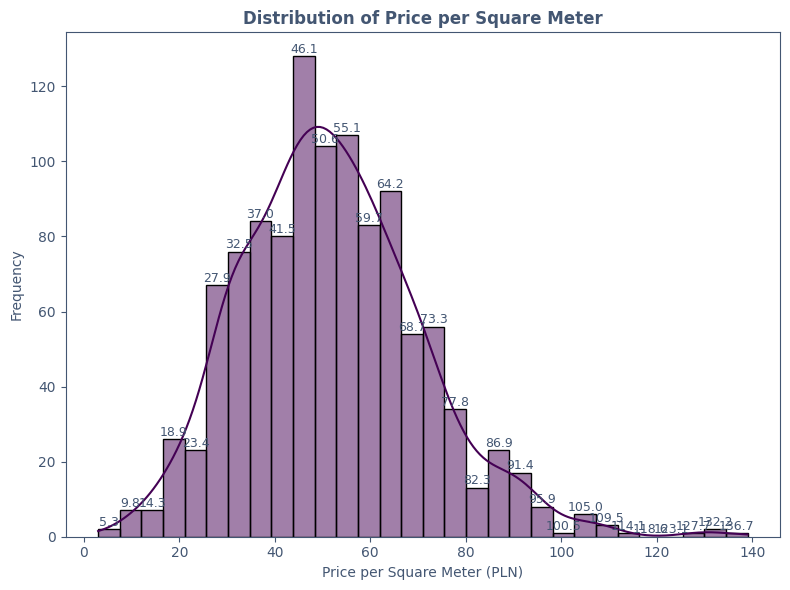

In [20]:
def plot_distribution(combined_df: pd.DataFrame):

    # Calculation with handling of potential division by zero or NaN values
    plot_data = (combined_df['pricing']['total_rent'] / combined_df['size']['square_meters']).replace([np.inf, -np.inf], np.nan)
    plot_data = plot_data.dropna().round().astype('float')

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))
    color = colors[0]
    title = 'Distribution of Price per Square Meter'

    fig, ax = plt.subplots(figsize=aesthetics_plots['figsize']['singleplot'])
    hist = sns.histplot(plot_data, kde=True, bins=30, color=color, ax=ax)
    ax.set_xlabel('Price per Square Meter (PLN)')
    ax.set_ylabel('Frequency')

    for p in hist.patches:
        bin_center = p.get_x() + p.get_width() / 2
        ax.annotate(f'{bin_center:.1f}', (bin_center, p.get_height()), 
                    ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], xytext=(0, 5),
                    textcoords='offset points')
        
    set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(combined_df)

**Insights:**

1. **Common Rent Prices**:<br>
Most apartments cost about `50 PLN` for each `square meter`.<br>
It's less common to find apartments that charge a lot more than this per square meter.

1. **Few Expensive Places**:<br>
The chart stretches out to the right, showing that while a few apartments have really high rent for each square meter,<br>
they're pretty rare. Most places stick close to the usual cost.

In [21]:
CategoryResults = list[Tuple[str, str, float]]

def get_correlations(data: pd.DataFrame):
    
    def get_correlation_category(bottom_threshold: float, upper_threshold: float = 1.0):

        category_results: CategoryResults = []
        num_columns = len(columns)

        for i in range(num_columns):
            for j in range(i+1, num_columns):

                corr_value = correlations.iloc[i, j]
                col_left = columns[i]
                col_right = columns[j]

                category_results = add_correlation_value(
                        bottom_threshold, 
                        upper_threshold, 
                        category_results, 
                        corr_value, 
                        col_left, 
                        col_right
                    )
        
        sorted_results = sorted(category_results, key=lambda x: x[2], reverse=True)
        return sorted_results

    def add_correlation_value(
                bottom_threshold: float, 
                upper_threshold: float, 
                category_results: CategoryResults, 
                corr_value: float, 
                col_left: str, 
                col_right: str
            ):

        if upper_threshold == 1.0:
            if bottom_threshold <= abs(corr_value):
                category_results.append((col_left, col_right, corr_value))
        else:
            if bottom_threshold <= abs(corr_value) < upper_threshold:
                category_results.append((col_left, col_right, corr_value))

        return category_results
    
    correlations = data.corr()
    columns = correlations.columns
    correlations_results = {}
    
    correlations_results['Strong Correlations'] = get_correlation_category(bottom_threshold = 0.7)
    correlations_results['Moderate Correlations'] = get_correlation_category(bottom_threshold = 0.3, upper_threshold = 0.7)
    correlations_results['Weak Correlations'] = get_correlation_category(bottom_threshold = 0.1, upper_threshold = 0.3)

    return correlations_results

def print_results(correlations_results: dict[str, CategoryResults]):

    for level, results in correlations_results.items():
        print(f"\n{level}:")
        for col_left, col_right, corr_value in results:
            print(f"{col_left} - {col_right}: {round(corr_value, 2)}")
        print("\r")

def print_correlations(data: pd.DataFrame):
    
    correlations_results = get_correlations(data)
    
    print_results(correlations_results)

def get_top_extreme_results(correlations_results: dict[str, CategoryResults], column_of_interest: str, num_positive_negative: int):

    top_positive = []

    positive_count = 0

    for _, results in correlations_results.items():

        for col_left, col_right, corr_value in results:

            if corr_value > 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if positive_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_positive.append(corr_item)

                    positive_count += 1

        if positive_count == num_positive_negative:
            break

    top_negative = []

    negative_count = 0

    reversed_dict = dict(reversed(correlations_results.items()))

    for _, results in reversed_dict.items():

        for col_left, col_right, corr_value in results:

            if corr_value < 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if negative_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_negative.insert(0, corr_item)

                    negative_count += 1

        if negative_count == num_positive_negative:
            break

    top_positive.extend(top_negative)

    return top_positive

In [22]:

def show_extreme_correlations(data: pd.DataFrame, column_of_interest: Tuple[str, str], num_results: int = 5, title: str = "Add title"):

    columns_to_drop = [('pricing', 'price'), ('pricing', 'rent')]
    data = data.drop(columns=columns_to_drop)
    correlations_results = get_correlations(data)
    extreme_correlations = get_top_extreme_results(correlations_results, column_of_interest, num_results)

    unique_elements = list(
        set([item[0] for item in extreme_correlations] + [item[1] for item in extreme_correlations])
    )
    correlation_values = np.zeros((len(unique_elements), len(unique_elements)))

    element_index_mapping = {
        element: index for index, element in enumerate(unique_elements)
    }

    for item in extreme_correlations:
        col1, col2, corr_value = item
        row_index = element_index_mapping[col2]
        col_index = element_index_mapping[col1]
        correlation_values[row_index, col_index] = corr_value

    df = pd.DataFrame(correlation_values, index=unique_elements, columns=unique_elements)
    df_column_of_interest = df[[column_of_interest]]
    df_no_empty_value = df_column_of_interest.drop(index=column_of_interest)
    df_no_0 = df_no_empty_value.drop(df_no_empty_value[df_no_empty_value.eq(0).all(axis=1)].index)
    df_plot = df_no_0.sort_values(by=column_of_interest, ascending=False)

    with plt.style.context('seaborn'):
        plt.figure(figsize=aesthetics_plots['figsize']['singleplot'])
        heatmap = sns.heatmap(df_plot, cmap='coolwarm', vmin = -1.0, vmax = 1.0, annot=True, fmt=".2f", annot_kws={'color': "white", 'fontweight': "bold"}, cbar=True, cbar_kws={"label": "Correlation"})
        # set color palette proportional to values 1.0 is always max 0.0 always least color value
        heatmap.set_xlabel("")
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, color=aesthetics_plots['label_color'])
        heatmap.set_xticklabels([])
        
        # Add the following lines
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([heatmap.collections[0].get_array().min(), heatmap.collections[0].get_array().max()])
        cbar.set_ticks([-1.0, 0, 1.0])  # Set the tick locations
        cbar.set_ticklabels(['-1.0', '0.0', '1.0'])  # Set the tick labelss
        cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color=aesthetics_plots['label_color'])  # Set the tick label color
        cbar.set_label("Correlation", color=aesthetics_plots['label_color'])
        
        plt.title(f'Correlation: {title}\n', color=aesthetics_plots['label_color'], fontsize = aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
        plt.show()


C:\Users\karol\AppData\Local\Temp\ipykernel_49360\1379042120.py:47: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()


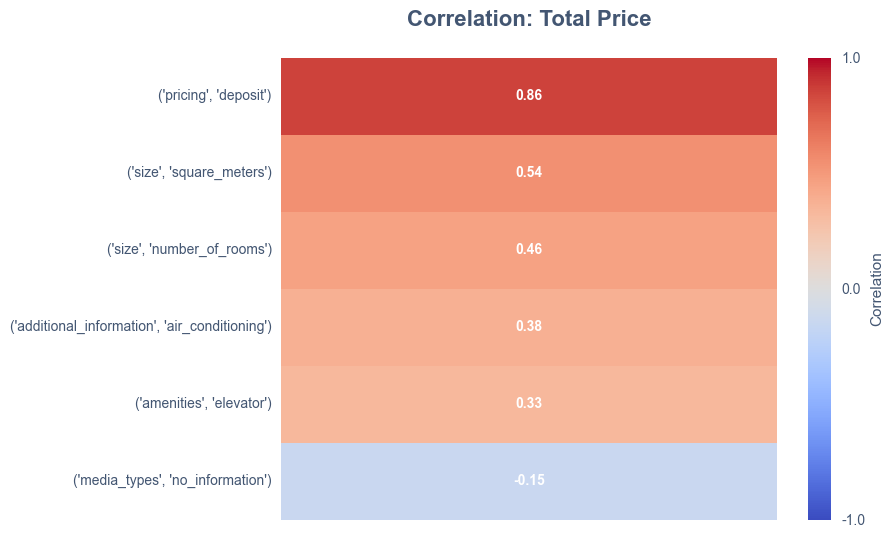

In [23]:
show_extreme_correlations(combined_df, ('pricing', 'total_rent'), title="Total Price")

**Insights:**

1. **Deposit and Total Price**:<br>
There is a strong positive relationship between the deposit amount and the total price, indicated by a correlation of `0.86`.<br>
This suggests that higher-priced rentals typically require a higher deposit.

1. **Size Matters**:<br>
The apartment size, measured in square meters, has a significant positive correlation `(0.54)` with the total price,<br>
meaning larger apartments tend to be more expensive.<br>
The number of rooms also shows a positive correlation `(0.46)` with price, though it's not as strong as the size in square meters,<br>indicating that the overall size may be more influential on price than the mere number of rooms.

1. **Features and Lack of Information**:<br>
Additional features like air conditioning have a moderate positive correlation `(0.38)` with total price,<br>
implying that apartments with air conditioning might be priced higher.<br>
Interestingly, there's a slight negative correlation `(-0.15)` with 'no information' provided in media types,<br>
which could suggest that listings with less information may be associated with slightly lower prices,<br>
or it might indicate a trend where less expensive listings provide fewer details.

Other correlations:

In [24]:
print_correlations(combined_df)

C:\Users\karol\AppData\Local\Temp\ipykernel_49360\1379042120.py:47: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()



Strong Correlations:
('pricing', 'price') - ('pricing', 'total_rent'): 0.98
('equipment', 'stove') - ('equipment', 'fridge'): 0.89
('equipment', 'fridge') - ('equipment', 'washing_machine'): 0.89
('pricing', 'price') - ('pricing', 'deposit'): 0.88
('pricing', 'total_rent') - ('pricing', 'deposit'): 0.86
('equipment', 'stove') - ('equipment', 'washing_machine'): 0.85
('equipment', 'stove') - ('equipment', 'oven'): 0.84
('equipment', 'fridge') - ('equipment', 'oven'): 0.78
('equipment', 'oven') - ('equipment', 'washing_machine'): 0.76
('media_types', 'internet') - ('media_types', 'cable_TV'): 0.73
('size', 'floor') - ('size', 'building_floors'): 0.71
('media_types', 'no_information') - ('media_types', 'cable_TV'): -0.79
('security', 'no_information') - ('security', 'intercom_or_video_intercom'): -0.85
('equipment', 'no_information') - ('equipment', 'furniture'): -0.87
('windows', 'no_information') - ('windows', 'plastic'): -0.93
('media_types', 'no_information') - ('media_types', 'inter

**Insights:**

1. **Price Consistency**:<br>
The almost perfect correlation `(0.98)` between `'pricing`' and `'price'` vs. `'total_rent'` suggests that the rent price consistently contributes to the total cost of renting, likely inclusive of additional fees or services.

1. **Equipment Bundling**:<br>
The strong correlations among various pieces of equipment (stove, fridge, washing machine, oven) ranging from `0.78` to `0.89` indicate that these are often bundled together in rental properties. If a rental has one of these appliances, it's very likely to have the others.

1. **Safety and Convenience Features**:<br>
There is a moderate positive correlation (`0.68` to `0.64`) between having certain appliances (stove, fridge, washing machine) and security features like intercom or video intercom systems. This could imply that properties equipped with modern conveniences also prioritize security.

### 2.3 Location

In [25]:
def count_and_percentage_with_distance(df, column_name, city_coords, city_populations):

    # Flatten the index to avoid groupby issues
    df_temp = pd.DataFrame()
    df_temp[str(column_name)] = df[column_name]
    column_name = str(column_name)
    df_temp['median_price (PLN)'] = df[('pricing', 'total_rent')]
    df_temp['square_meters'] = df[('size', 'square_meters')]

    if column_name not in df_temp.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    # Calculate count and percentage
    count = df_temp[column_name].value_counts(dropna=False)
    percentage = df_temp[column_name].value_counts(dropna=False, normalize=True) * 100

    # Create a DataFrame from the count and percentage
    result = pd.DataFrame({
        'Count': count,
        'Percentage': percentage
    }).reset_index()

    # Rename the 'index' column to the actual column name for clarity
    result.rename(columns={'index': column_name}, inplace=True)

    # Add median ('pricing', 'total_rent')
    grouped = df_temp.groupby(column_name)
    median_rent = grouped['median_price (PLN)'].median()
    median_sqm = grouped['square_meters'].median()

    result = result.join(median_rent, on=column_name)
    result = result.join(median_sqm, on=column_name)

    # Calculate median price per square meter for each city
    result['Median Price per Sq Meter (PLN)'] = (result['median_price (PLN)'] / result['square_meters']).round(2)

    # Reorder columns to move 'Median Price per Sq Meter (PLN)' to the 5th position
    cols = list(result.columns)
    cols.insert(4, cols.pop(cols.index('Median Price per Sq Meter (PLN)')))
    result = result[cols]

    # Calculate the distance from the central city for each city
    central_city = 'Mierzęcice, Będziński, Śląskie'
    central_city_coords = city_coords['central_city'][central_city]
    
    result[f'Distance from {central_city} (km)'] = result.apply(
        lambda row: round(haversine(central_city_coords, city_coords['distance_from_central_city'].get(row[column_name], (None, None)), unit='km'), 2)
        if row[column_name] in city_coords['distance_from_central_city'] else None, axis=1)

    # Add city population information
    result['City Population (Thousands)'] = result[column_name].map(city_populations)

    return result

In [26]:
city_populations = {
    "Katowice": 286,
    "Sosnowiec": 191,
    "Bytom": 161,
    "Dąbrowa Górnicza": 116,
    "Chorzów": 105,
    "Jaworzno": 89,
    "tarnogórski": 45, # Rular area
    "będziński": 38, # Rular area
    "Siemianowice Śląskie": 65,
    "Mysłowice": 72,
    "Piekary Śląskie": 54,
    "Świętochłowice": 49,
    "Ruda Śląska": 135,
    "myszkowski": 32, # Rular area
    "częstochowski": 119, # Rular area
    "zawierciański": 43,  # Rular area
    "Zawada": 0.16  # Rular area
}

city_coords = {
    "central_city": {
        "Mierzęcice, Będziński, Śląskie": (50.4441, 19.12405)
    },
    "distance_from_central_city": {
        "Katowice": (50.258598, 19.020420),
        "Sosnowiec": (50.286263, 19.104078),
        "Bytom": (50.348160, 18.917561),
        "Dąbrowa Górnicza": (50.325910, 19.187200),
        "Chorzów": (50.297642, 18.955420),
        "Jaworzno": (50.203439, 19.272156),
        "tarnogórski": (50.444241, 18.856491),
        "będziński": (50.415352, 19.11304),
        "Siemianowice Śląskie": (50.30563, 19.028088),
        "Mysłowice": (50.209621, 19.132166),
        "Piekary Śląskie": (50.375779, 18.937939),
        "Świętochłowice": (50.298945, 18.907466),
        "Ruda Śląska": (50.270348, 18.864388),
        "myszkowski": (50.605529, 19.294746),
        "częstochowski": (50.7979, 19.1247),
        "zawierciański": (50.54427, 19.619602),
        "Zawada": (50.43734, 19.096938),
    }
}

locations_summary = count_and_percentage_with_distance(combined_df, ("location", "city"), city_coords, city_populations)
locations_summary

,"('location', 'city')",Count,Percentage,median_price (PLN),Median Price per Sq Meter (PLN),square_meters,"Distance from Mierzęcice, Będziński, Śląskie (km)",City Population (Thousands)
0,Katowice,514,46.473779,2600.0,57.78,45.0,21.90,286.00
1,Sosnowiec,145,13.110307,2000.0,45.45,44.0,17.61,191.00
2,Bytom,122,11.030741,1610.0,38.8,41.5,18.11,161.00
3,Dąbrowa Górnicza,68,6.148282,2200.0,47.31,46.5,13.88,116.00
4,Chorzów,61,5.515371,1800.0,46.15,39.0,20.21,105.00
5,Jaworzno,36,3.254973,1800.5,45.01,40.0,28.75,89.00
6,tarnogórski,33,2.983725,1986.0,41.38,48.0,18.95,45.00
7,będziński,32,2.893309,1965.0,44.66,44.0,3.29,38.00
8,Siemianowice Śląskie,23,2.079566,1750.0,41.67,42.0,16.83,65.00
9,Mysłowice,21,1.898734,2000.0,38.46,52.0,26.08,72.00


In [27]:
locations_summary[["('location', 'city')", "median_price (PLN)", "Median Price per Sq Meter (PLN)"]].sort_values(by="median_price (PLN)", ascending=False)

,"('location', 'city')",median_price (PLN),Median Price per Sq Meter (PLN)
0,Katowice,2600.0,57.78
3,Dąbrowa Górnicza,2200.0,47.31
9,Mysłowice,2000.0,38.46
1,Sosnowiec,2000.0,45.45
6,tarnogórski,1986.0,41.38
7,będziński,1965.0,44.66
16,Zawada,1900.0,73.08
5,Jaworzno,1800.5,45.01
4,Chorzów,1800.0,46.15
13,myszkowski,1800.0,33.96


**Insights**:

1. Higher Rents in Larger Cities: Katowice, the largest city with `286,000 people`, leads in both the number of listings `(514)` and rent prices. It has a median rent of `2600 PLN` and a price of `57.78 PLN` per square meter. This shows that in bigger cities like Katowice, living costs, including rent, are generally higher.

1. Rent Increases with City Size: In larger cities, rent tends to be pricier. For example, `Katowice` and `Sosnowiec`, with larger populations, have median rents of `2600 PLN` and `2000 PLN`, respectively. In contrast, smaller areas like `Zawiercie` and `Myszkowski` have significantly lower rents.

1. Location's Influence on Rent: The distance from `Mierzęcice`, `Będziński, Śląskie` impacts rent. Closer locations like `Będziński` (`3.29 km` away) have a lower price per square meter (`44.66 PLN`) compared to further cities like `Jaworzno` (`28.75 km` away) with `45.01 PLN` per square meter. This indicates that proximity to a central point can influence rental prices.

In [46]:
geolocator = Nominatim(user_agent="your_app_name")

def get_coordinates(address, attempt=1, max_attempts=3):
    try:
        location = geolocator.geocode(address, timeout=10)  # Increase timeout to 10 seconds
        if location:
            return (location.latitude, location.longitude)
        else:
            return (None, None)
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            time.sleep(1 * attempt)  # Exponential backoff
            return get_coordinates(address, attempt + 1, max_attempts)
        return (None, None)
    except GeocoderUnavailable:
        return (None, None)

def add_geo_data_to_offers(df: pd.DataFrame):

    df_temp = pd.DataFrame()
    df_temp['complete_address'] = df[('location', 'complete_address')]
    df_temp['city'] = df[('location', 'city')] + ", " + df[('location', 'voivodeship')]
    df_temp['price_total'] = df[('pricing', 'total_rent')]
    df_temp['price'] = df[('pricing', 'price')]
    df_temp['rent'] = df[('pricing', 'rent')]
    df_temp['sqm'] = df[('size', 'square_meters')]

    # Create unique address list
    unique_addresses = df[('location', 'complete_address')].unique()
    address_coords = {}

    for address in unique_addresses:
        coords = get_coordinates(address)
        if coords == (None, None):
            # If coordinates for the complete address are not found, try with city
            city = df_temp[df_temp['complete_address'] == address]['city'].values[0]
            coords = get_coordinates(city)
        address_coords[address] = coords

    # Map the coordinates back to the DataFrame
    df_temp['coords'] = df_temp['complete_address'].map(address_coords)

    return df_temp

map_df = add_geo_data_to_offers(combined_df)

,complete_address,city,price_total,price,rent,sqm,coords
732,"ul. Powstańców, Centrum, Chorzów, śląskie","Chorzów, śląskie",990.0,990.0,NaN,13,"(50.288556299999996, 18.97044253093511)"
826,"Rozbark, Bytom, śląskie","Bytom, śląskie",1600.0,1600.0,NaN,77,"(50.34116775, 18.94177421942872)"
414,"Pogoń, Sosnowiec, śląskie","Sosnowiec, śląskie",1200.0,1200.0,NaN,39,"(50.2932332, 19.1281052)"
585,"ul. Nomiarki, Chorzów II, Chorzów, śląskie","Chorzów, śląskie",2490.0,2200.0,290.0,28,"(50.288556299999996, 18.97044253093511)"
1037,"Górka Gołonoska, Gołonóg Wschodni, Dąbrowa Gór...","Dąbrowa Górnicza, śląskie",2000.0,2000.0,NaN,30,"(50.369624, 19.289046489684473)"


In [49]:
len(map_df['coords'].unique())

112

In [50]:
map_df.dtypes

complete_address     string
city                 string
price_total         float64
price               float64
rent                float64
sqm                   Int64
coords               object
dtype: object

### 2.4 Attributes and equipment

In [37]:
# TODO - percentage of equipment in cities